# **Programming for Data Analysis**
---

**Author: Damien Farrell**

---

## Project 1:
## Simulation of House Prices in Ireland

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import gamma
import httpx
from selectolax.parser import HTMLParser
import time
import warnings

In [2]:
# Set seed for reproducibility
np.random.seed(10)

# Number of samples
num_samples = 1000

### **Introduction**
For this data analytics project, I have chosen to simulate a dataset related to house prices in Ireland. 

I needed to figure out some simple house statistics such as the average floor area and the minimum house price. The CSO (Central Statistic Office) only provides simulated datasets. Simulating data on a simuted dataset may not be idea so I decided to scrape a sample number of properties on daft.ie.

### **Variables**

1. Price
1. Floor Area
1. Number of Bedrooms
1. Property Type
1. Location

In [3]:
def get_html(baseurl, page):
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:120.0) Gecko/20100101 Firefox/120.0"}
    resp = httpx.get(baseurl + str((page*20)-20), headers=headers)
    resp.raise_for_status()
    try:
        resp.raise_for_status()
    except httpx.HTTPStatusError as exc:
        print(f"Error response {exc.response.status_code} while requesting {exc.request.url!r}. Page Limit Exceeded")
        return False # Returns False when it exceeds the last webpage in order to stop the loop.
    html = HTMLParser(resp.text)
    return html

In [4]:
def extract_text(html, sel):
    try:
        text = html.css_first(sel).text(strip=True)
        return clean_data(text)
    except AttributeError:
        return None

In [5]:
def parse_page(html):
    card_elements = html.css("div[data-testid='card-body']")

    for card_element in card_elements:
        property_info = {
            "Address": extract_text(card_element, "[data-testid='address']"),
            "Price": extract_text(card_element, "[data-testid='price']"),
            "Bedrooms": extract_text(card_element, "[data-testid='beds']"),
            "Bathrooms": extract_text(card_element, "[data-testid='baths']"),
            "Floor Area": extract_text(card_element, "[data-testid='floor-area']"),
            "Property Type": extract_text(card_element, "[data-testid='property-type']")
        }
        yield property_info

In [6]:
def clean_data(value):
    chars_to_remove = ["€", "m²", "Bed", "Bath", "ONLINE OFFERS", "ONLINE OFFER", "AMV:"]
    for char in chars_to_remove:
        if char in value:
            value = value.replace(char, "")
    return value.strip()

In [7]:
def daft_scraper(num_of_pages_to_scrape = 11):
    baseurl = "https://www.daft.ie/property-for-sale/ireland?pageSize=20&from="
    df_list = []
    
    print("Gathering Page:")
    for x in range(1,num_of_pages_to_scrape):
        print(f"{x}", end=" ")
        html = get_html(baseurl, x)
        if html is False:
            break
        data = parse_page(html)

        for item in data:
            df_list.append(item)
            
        time.sleep(0.1)

    scraped_df = pd.DataFrame(df_list)
    
    scraped_df["Price"] = pd.to_numeric(scraped_df["Price"].str.replace(",", ""), errors="coerce")
    scraped_df["Bedrooms"] = pd.to_numeric(scraped_df["Bedrooms"], errors="coerce")
    scraped_df["Bathrooms"] = pd.to_numeric(scraped_df["Bathrooms"], errors="coerce")
    scraped_df["Floor Area"] = pd.to_numeric(scraped_df["Floor Area"], errors="coerce")

    return scraped_df

In [8]:
scraped_df = daft_scraper(51)

Gathering Page:
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

In [9]:
df = pd.DataFrame()
df["Price"] = scraped_df["Price"].fillna(0).astype(int)
df["Bedrooms"] = scraped_df["Bedrooms"].fillna(0).astype(int)
df["Floor Area"] = scraped_df["Floor Area"].fillna(0).astype(int)
df["Property Type"] = scraped_df["Property Type"].astype("category")
df["Eircode"] = scraped_df["Address"].str.rsplit(',', n=1).str[-1]
df["Eircode"] = df["Eircode"].str[:4]

df = df[(df["Price"] != 0) & (df["Bedrooms"] != 0) & (df["Floor Area"] != 0) & (df["Property Type"] != "Site") & (df["Price"] < 2_000_000) & (df["Floor Area"] < 500)]

df.dropna(inplace=True)
df["Property Type"] = df["Property Type"].cat.remove_unused_categories()

df.reset_index(drop=True, inplace=True)

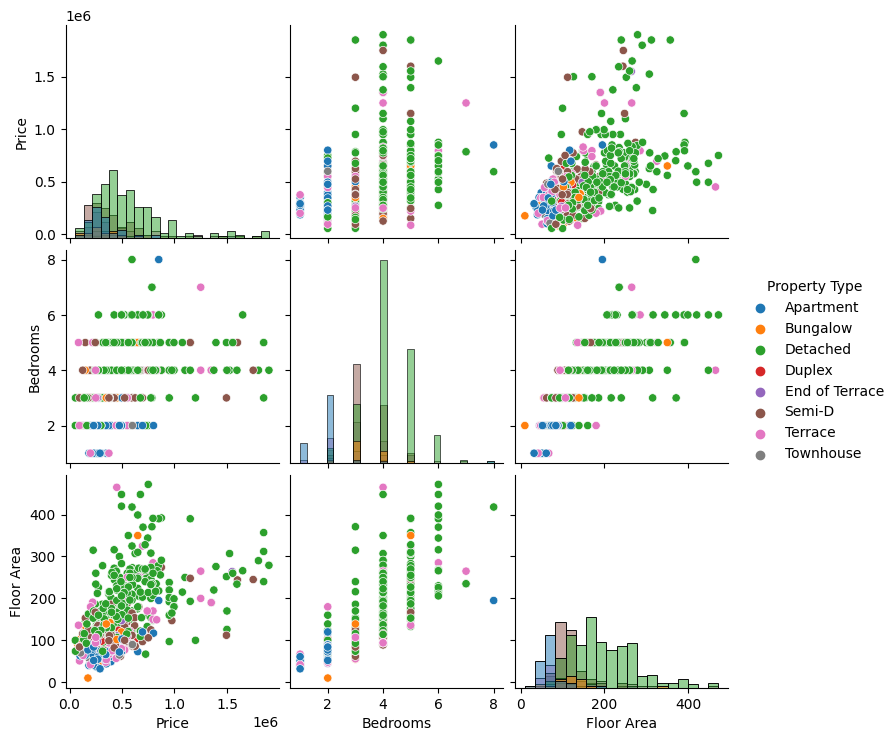

In [10]:
sns.pairplot(df, hue="Property Type", diag_kind='hist');

<Axes: title={'center': 'Heatmap: Correlation'}>

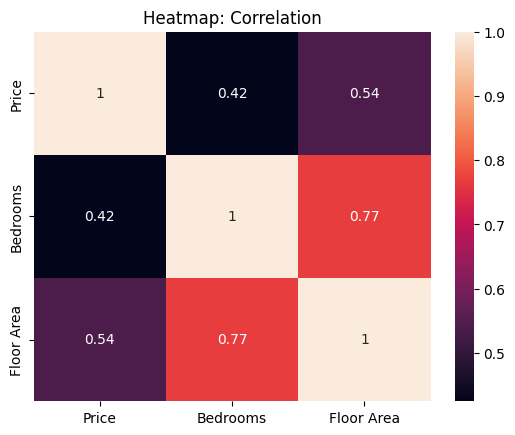

In [11]:
df_corr = df[['Price','Bedrooms','Floor Area']].corr()
plt.title('Heatmap: Correlation')
sns.heatmap(df_corr, annot=True)

### **House Price:**

This variable represents the market value of a house. It will be a continuous variable with a positive integer format.

**Data Generation**

Simulate house prices using a normal distribution. Research on local housing markets can provide insights into the mean and standard deviation for generating realistic price data.

Function made in other module. Fundamentals.

**Function distribution_test(variable_name) to automatically identify the best-fitting distribution among multiple continuous variable candidates using Kolmogorov–Smirnov Test (KS), P-Values, and  Akaike Information Criterion (AIC)**

In [26]:
def distribution_test(variable_name):
    
    results = []  # To store the results
    numpy_distributions = ['beta', 'chi2', 'expon', 'f', 'gamma', 'gumbel_r', 'gumbel_l', 'laplace', 'logistic', 'lognorm', 'norm', 'pareto', 
                           'powerlaw', 'powerlognorm', 'rayleigh', 'cauchy', 'exponpow', 't', 'triang', 'uniform', 'wald', 'weibull_min', 'weibull_max']

    for distribution in numpy_distributions:
        params = getattr(stats, distribution).fit(variable_name)
        stat, p_value = stats.kstest(variable_name, distribution, args=params)
        
        # Calculate AIC
        dist = getattr(stats, distribution)(*params)
        log_likelihood = dist.logpdf(variable_name).sum()
        k = len(params)  # Number of parameters
        aic = 2 * k - 2 * log_likelihood
        
        # Store the results in a dictionary
        result = {
            'Distribution': distribution,
            'KS Statistic': stat,
            'P-value': p_value,
            'AIC': aic
        }
        results.append(result)

    # Create a DataFrame from the results
    test_df = pd.DataFrame.from_dict(results)
    test_df = test_df.sort_values(by='KS Statistic', ascending=True).reset_index(drop=True).head(10)
    
    return test_df

In [27]:
# Ignore specific warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

The price data looked like it was too wide ranging so it was transformed into logarithm.

In [28]:
transformed_price = np.log(df["Price"])

In [29]:
distribution_test(transformed_price)

,Distribution,KS Statistic,P-value,AIC
0,beta,0.023907,0.910806,970.859622
1,gamma,0.026071,0.848397,968.221840
2,lognorm,0.026285,0.841478,968.214997
3,f,0.026360,0.838999,970.213898
4,powerlognorm,0.026564,0.832230,970.122375
5,chi2,0.026870,0.821898,970.433449
6,t,0.027443,0.801928,966.735839
7,norm,0.028754,0.754033,966.349015
8,logistic,0.031230,0.658496,968.663728
9,weibull_max,0.033045,0.587755,971.814033


In [51]:
mean_price = df["Price"].mean()
sigma_price = df["Price"].std()

# Convert these parameters to the mean of the log-normal distribution
mean_log = np.log(mean_price**2 / np.sqrt(mean_price**2 + sigma_price**2))
sigma_log = np.sqrt(np.log(1 + (sigma_price**2 / mean_price**2)))

simulated_house_price = np.random.lognormal(mean_log, sigma_log, num_samples)

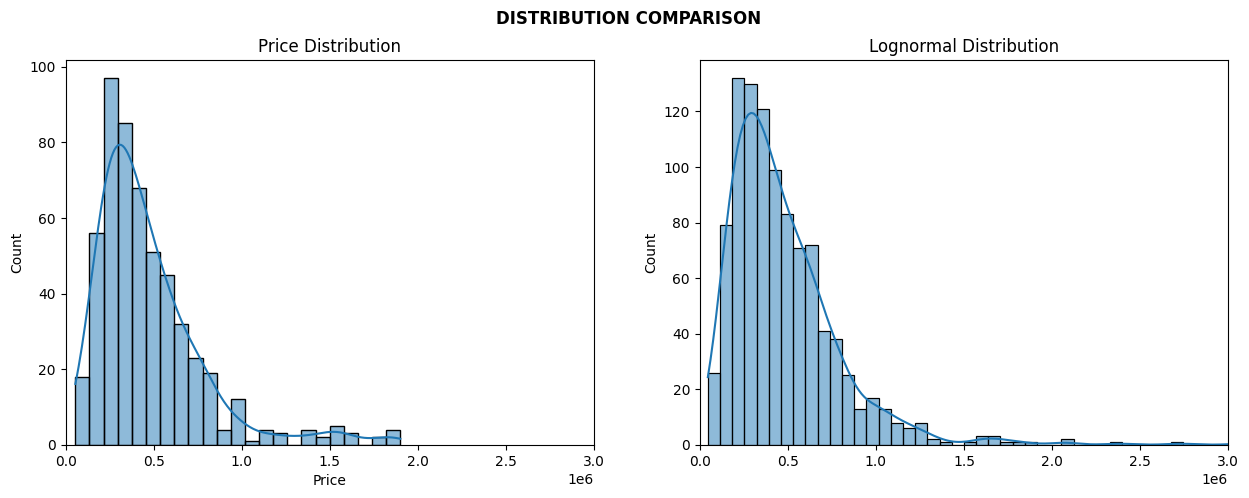

In [53]:
figure, axes = plt.subplots(1, 2, figsize=(15, 5))
figure.suptitle('DISTRIBUTION COMPARISON', fontweight='bold')

axes[0].set_title('Price Distribution')
axes[0].set_xlim(0, 3_000_000)
sns.histplot(df["Price"], kde=True, ax=axes[0])

axes[1].set_title('Lognormal Distribution')
axes[1].set_xlim(0, 3_000_000)
sns.histplot(simulated_house_price, kde=True, ax=axes[1]);

### **Floor Area:**

The floor area of the house in meters squared. This will be a positive integer.

**Data Generation**


Simulate house size using a normal distribution.

In [32]:
transformed_floor_area = np.log(df["Floor Area"])

In [33]:
distribution_test(transformed_floor_area)

,Distribution,KS Statistic,P-value,AIC
0,chi2,0.034125,0.546440,851.379638
1,gamma,0.035770,0.485638,845.360723
2,lognorm,0.041824,0.295206,841.490214
3,norm,0.044199,0.236922,839.036086
4,f,0.044466,0.230937,843.197244
5,t,0.046019,0.198421,839.884440
6,logistic,0.047233,0.175562,850.793860
7,weibull_min,0.049502,0.138448,inf
8,weibull_max,0.052329,0.101380,837.693039
9,powerlognorm,0.053956,0.084061,841.484623


This code uses the gamma.fit function from SciPy to estimate the shape &&α&& , location (loc), and scale (β) parameters of the gamma distribution that best fit your floor area data.

In [54]:
alpha, loc, beta = stats.gamma.fit(df["Floor Area"])

# Generate random samples from the fitted distribution
gamma_samples = gamma.rvs(alpha, loc=loc, scale=beta, size=len(df["Floor Area"]))

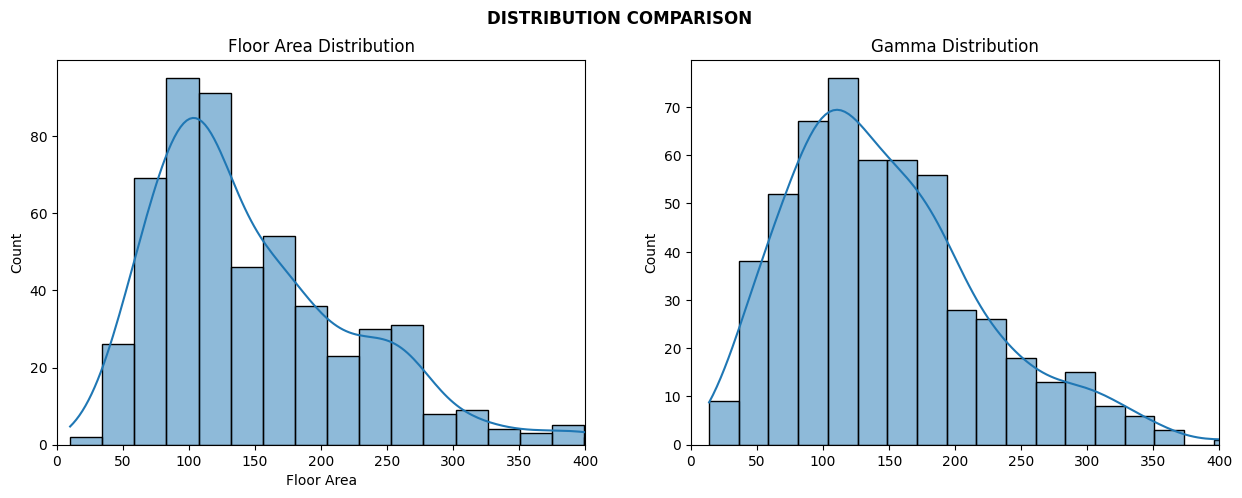

In [55]:
figure, axes = plt.subplots(1, 2, figsize=(15, 5))
figure.suptitle('DISTRIBUTION COMPARISON', fontweight='bold')

axes[0].set_title('Floor Area Distribution')
axes[0].set_xlim(0, 400)
sns.histplot(df["Floor Area"], kde=True, ax=axes[0])

axes[1].set_title('Gamma Distribution')
axes[1].set_xlim(0, 400)
sns.histplot(gamma_samples, kde=True, ax=axes[1]);

#### **Number of Bedrooms:**

The count of bedrooms in a house. This will be a positive integer.

**Data Generation**

Simulate the number of bedrooms using a discrete distribution. Research on typical bedroom counts in houses can guide the distribution.

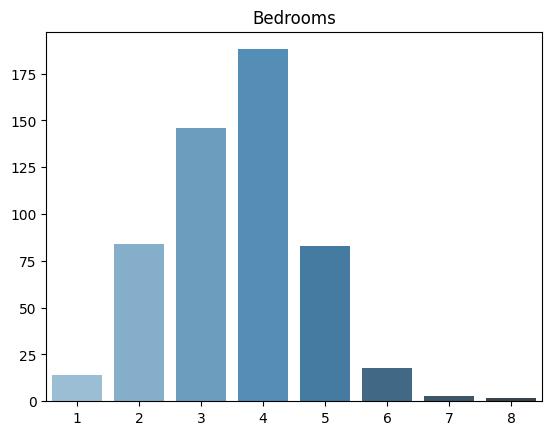

In [185]:
c = df["Bedrooms"].value_counts()
sns.barplot(x=c.index,y=c.values, palette='Blues_d')
plt.title('Bedrooms');

In [176]:
count_of_bedrooms = df["Bedrooms"].value_counts()
sum_of_bedrooms = count_of_bedrooms.sum()

bedroom_distribution = (count_of_bedrooms / sum_of_bedrooms).sort_index()

Need to add noise!!!

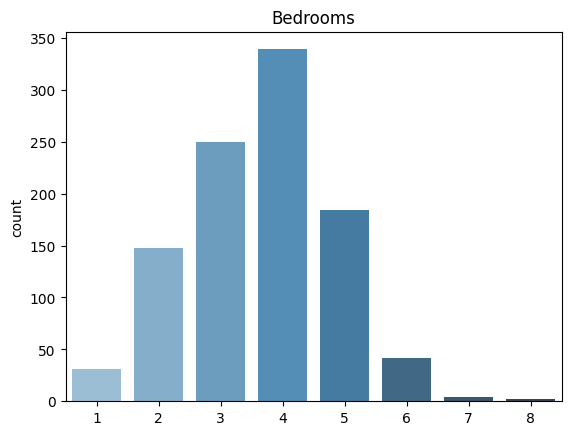

In [186]:
p = bedroom_distribution.tolist()

bedroom_count = np.random.choice([1, 2, 3, 4, 5, 6, 7, 8], size=num_samples, p=p)

sns.countplot(x=bedroom_count, palette='Blues_d')
plt.title('Bedrooms');

### **Location**

Geographic variable representing the location of the house.

**Data Generation**

?

In [ ]:
latitude = 53.3498
longitude = -6.2603

sns.scatterplot(x=[latitude],y=[longitude]);

In [ ]:
# Create DataFrame
house_data = pd.DataFrame({
    'House_Price': house_prices.round(2),
    'House_Size': house_size.round(2),
    'Bedrooms': bedroom_count,
})

house_data.head()

### **Relationships**

**Correlation between House Price and House Size:**

Simulate a positive correlation between house price and house size, as larger houses generally tend to have higher prices.

**Influence of Number of Bedrooms:**

Simulate an influence of the number of bedrooms on house price. Larger houses with more bedrooms should have higher prices.

**Geographic Location Impact:**

Introduce a relationship between geographic location and house price. Certain geographic areas may positively or negatively influence house prices.


https://www.spcforexcel.com/knowledge/basic-statistics/deciding-which-distribution-fits-your-data-best/


https://statisticsbyjim.com/hypothesis-testing/identify-distribution-data/
https://statisticsbyjim.com/basics/goodness-of-fit/
https://statisticsbyjim.com/basics/skewed-distribution/

https://docs.scipy.org/doc/scipy/reference/stats.html

Note that this example covers continuous data. For categorical and discrete variables, you should use the chi-square goodness of fit test.

https://statisticsbyjim.com/hypothesis-testing/chi-square-goodness-of-fit-test/



https://archive.ph/20230811082152/https://towardsdatascience.com/how-to-find-the-best-theoretical-distribution-for-your-data-a26e5673b4bd#selection-643.182-653.170

https://www.datacamp.com/tutorial/probability-distributions-python

https://www.analyticsvidhya.com/blog/2021/09/q-q-plot-ensure-your-ml-model-is-based-on-the-right-distributions/https://archive.ph/20221125141253/https://towardsdatascience.com/understand-q-q-plot-using-simple-python-4f83d5b89f8f#selection-965.3-979.30

https://numpy.org/doc/1.16/reference/routines.random.html

https://stackoverflow.com/questions/45579525/returning-a-dataframe-in-python-function

https://www.geeksforgeeks.org/multi-plot-grid-in-seaborn/


https://stackoverflow.com/questions/6871201/plot-two-histograms-on-single-chart


https://stackoverflow.com/questions/69141790/seaborn-reg-plots-with-the-same-y-axis-scale-side-by-side


Right Skewed. The mean overestimates the most common values in a positively skewed distribution.

Using a QQ Plot to determine if the dristribution follows a probability distribution...?

https://docs.scipy.org/doc/scipy/tutorial/stats/continuous_gumbel_l.html


https://www.statista.com/statistics/1417857/ireland-mean-new-home-size/

https://ec.europa.eu/eurostat/cache/digpub/housing/bloc-1b.html?lang=en

https://www.cso.ie/en/interactivezone/syntheticdata/housepricesyntheticdataset/

https://en.wikipedia.org/wiki/Parametric_statistics

https://www.youtube.com/@JohnWatsonRooney/videos

https://www.youtube.com/watch?v=1PCWwK0AsE0
https://www.youtube.com/watch?v=ZgVus_rmDBQ

https://visual.cso.ie/?body=entity/rppi

https://stackoverflow.com/questions/51607400/how-to-extract-first-8-characters-from-a-string-in-pandas

https://www.youtube.com/watch?v=xtTX69JZ92w

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.exponpow.html

https://stackoverflow.com/questions/2896179/fitting-a-gamma-distribution-with-python-scipy

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html

https://datatofish.com/convert-pandas-dataframe-to-list/

***Add more references and sort them out.***

***
# End